In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-8ytvd473
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-8ytvd473
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 8b14fc7bb6d42d67da6c33ac9bfaf3c024dbaff8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timm: filename=timm-1.0.8.dev0-py3-none-any.whl size=2303210 sha256=622fa989b74bfe5389c4a5e373827feb9002468787455aa5b6a9e92bcaf6d672
  Stored in directory: /tmp/pip-ephem-wheel-cache-dk3789p7/wheels/ed/07/8c/d16ff40e1a6ab5eff4240181152d83e10a933e1973397a1fec
Successfully built timm
  Attempting uninstall: timm
    Found existing installation: timm 1.0.7
    Uninstalling timm-1.0.7:
      Successfully uninstalled timm-1.0.7


In [2]:
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
!pip install torchinfo
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [3]:
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms.v2 as v2


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
dir_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
test_ds = os.path.join(dir_path, 'test')
train_ds = os.path.join(dir_path, 'train')

In [7]:
train = ImageFolder(train_ds)
test = ImageFolder(test_ds)

class_map = {0:'Mild Demented', 1:'Moderate Demented', 2:'Non Demented', 3:'Very Mild Demented'}
class_dict = dict(Counter(train.targets))
class_dict

{0: 717, 1: 52, 2: 2560, 3: 1792}

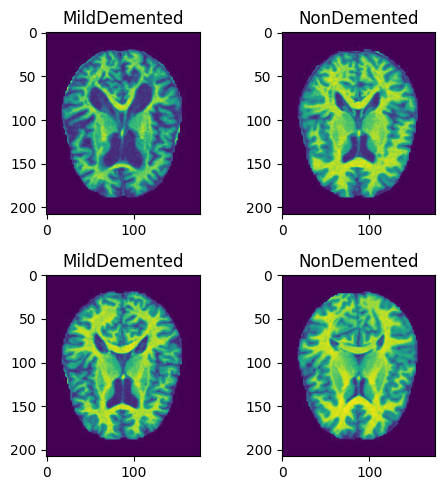

In [8]:
image_paths = []
for path in train.imgs:
    image_paths.append(path[0])
shuffled = image_paths.copy()
random.shuffle(shuffled)
plt.figure(figsize=(5,5))
for i, path in enumerate(shuffled):
    if i>3: break
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    image_class = Path(path).parent.stem
    plt.title(image_class)
    plt.imshow(img)
plt.tight_layout()

In [9]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx][0])
        class_category = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, class_category

In [10]:
transforms.functional.get_image_size(Image.open(train.imgs[1][0]))

[176, 208]

In [11]:
torchvision.transforms.functional.get_image_num_channels(Image.open(train.imgs[1][0]))

1

In [12]:
train_transform = v2.Compose([
                v2.Resize((224,224)),
                transforms.Grayscale(num_output_channels=3),
                v2.ToTensor()
])

test_transform = v2.Compose([
                v2.Resize((224,224)),
                transforms.Grayscale(num_output_channels=3),
                v2.ToTensor()
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [13]:
train_data, train_label = train.imgs, train.targets
test_data, test_label = test.imgs, test.targets

#os.path.join(dir_path,train_data)
train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [14]:
train_dataset

In [15]:
import torch
from torch.utils.data import Subset, ConcatDataset
from sklearn.model_selection import StratifiedShuffleSplit

# Merge train and test data and labels
all_data = ConcatDataset([train_dataset, test_dataset])

# Extract labels from the combined dataset
labels = [label for _, label in all_data]

# Perform stratified shuffle split for train and test
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices_1, test_indices = next(sss_train_test.split(torch.zeros(len(labels)), labels))

# Create Subset objects for train and test sets
train_data_1 = Subset(all_data, train_indices_1)
test_data = Subset(all_data, test_indices)

# Extract labels from the train subset for train-validation split
train_labels_1 = [label for _, label in train_data_1]

# Perform stratified shuffle split for train and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss_train_val.split(torch.zeros(len(train_labels_1)), train_labels_1))

# Create Subset objects for train and validation sets
train_data = Subset(train_data_1, train_indices)
val_data = Subset(train_data_1, val_indices)


In [16]:
from collections import defaultdict

# Define a dictionary to store the counts of images in each class
train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

# Iterate over train_data and count the occurrences of each class label
for _, label in train_data:
    train_class_counts[label] += 1

# Iterate over val_data and count the occurrences of each class label
for _, label in val_data:
    val_class_counts[label] += 1

# Iterate over test_data and count the occurrences of each class label
for _, label in test_data:
    test_class_counts[label] += 1

# Print the counts for train, val, and test datasets
print("Train Dataset Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nValidation Dataset Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest Dataset Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train Dataset Class Counts:
Class 2: 2048 images
Class 3: 1433 images
Class 0: 574 images
Class 1: 41 images

Validation Dataset Class Counts:
Class 2: 512 images
Class 3: 359 images
Class 0: 143 images
Class 1: 10 images

Test Dataset Class Counts:
Class 3: 448 images
Class 0: 179 images
Class 2: 640 images
Class 1: 13 images


**Data loaded after stratified shuffle split**

In [17]:
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [18]:
num_classes = 4
model = timm.create_model('pit_ti_224', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, num_classes)
model.to(device)
summary(model, (3, 224, 224))  # Assumes input images of size (3, 224, 224)

model.safetensors:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 4]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [19]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [20]:
# Define the loss function and optimizer
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), lr=0.0009)
scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

criterion = nn.CrossEntropyLoss()


In [21]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=10, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_weights = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
        else:
            self.best_score = score
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict()

In [22]:
# Initialize early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

total_epochs = 20

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()

    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")

    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])

    scheduler.step()

    # Check early stopping
    early_stopping_callback(val_metrics['loss'], model)
    if early_stopping_callback.early_stop:
        print("Early stopping triggered")
        break

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/20]: 100%|██████████| 64/64 [00:19<00:00,  3.25it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.1710, accuracy: 0.4695, precision: 0.4045, recall: 0.4695, f1_score: 0.4064, specificity: 0.0226, sensitivity: 0.9815, mcc: 0.0141, auc: 0.5205


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.14it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0706, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6627


Training Model - Epoch [2/20]: 100%|██████████| 64/64 [00:18<00:00,  3.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0600, accuracy: 0.4536, precision: 0.3693, recall: 0.4536, f1_score: 0.4015, specificity: 0.0000, sensitivity: 1.0000, mcc: -0.0053, auc: 0.5102


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0865, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6756


Training Model - Epoch [3/20]: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0523, accuracy: 0.4783, precision: 0.3736, recall: 0.4783, f1_score: 0.3890, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0018, auc: 0.5135


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.19it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.1056, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6844


Training Model - Epoch [4/20]: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0423, accuracy: 0.4875, precision: 0.3791, recall: 0.4875, f1_score: 0.3918, specificity: 0.0000, sensitivity: 0.9997, mcc: 0.0213, auc: 0.5304


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.15it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0240, accuracy: 0.5107, precision: 0.4561, recall: 0.5107, f1_score: 0.3693, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0799, auc: 0.6833


Training Model - Epoch [5/20]: 100%|██████████| 64/64 [00:18<00:00,  3.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9981, accuracy: 0.5229, precision: 0.4834, recall: 0.5229, f1_score: 0.4679, specificity: 0.0052, sensitivity: 0.9986, mcc: 0.1354, auc: 0.6018


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.12it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9844, accuracy: 0.5264, precision: 0.5189, recall: 0.5264, f1_score: 0.4902, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2417, auc: 0.7052


Training Model - Epoch [6/20]: 100%|██████████| 64/64 [00:18<00:00,  3.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9831, accuracy: 0.5168, precision: 0.4713, recall: 0.5168, f1_score: 0.4722, specificity: 0.0261, sensitivity: 0.9895, mcc: 0.1336, auc: 0.6346


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9569, accuracy: 0.5537, precision: 0.5012, recall: 0.5537, f1_score: 0.5177, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2459, auc: 0.7035


Training Model - Epoch [7/20]: 100%|██████████| 64/64 [00:20<00:00,  3.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9605, accuracy: 0.5400, precision: 0.4910, recall: 0.5400, f1_score: 0.4988, specificity: 0.0192, sensitivity: 0.9901, mcc: 0.1859, auc: 0.6669


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9370, accuracy: 0.5439, precision: 0.4723, recall: 0.5439, f1_score: 0.5043, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2063, auc: 0.7137


Training Model - Epoch [8/20]: 100%|██████████| 64/64 [00:19<00:00,  3.21it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9437, accuracy: 0.5398, precision: 0.5150, recall: 0.5398, f1_score: 0.5074, specificity: 0.0488, sensitivity: 0.9867, mcc: 0.1952, auc: 0.6835


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9305, accuracy: 0.5420, precision: 0.4688, recall: 0.5420, f1_score: 0.5020, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1999, auc: 0.7176


Training Model - Epoch [9/20]: 100%|██████████| 64/64 [00:20<00:00,  3.17it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9312, accuracy: 0.5544, precision: 0.5366, recall: 0.5544, f1_score: 0.5193, specificity: 0.0401, sensitivity: 0.9918, mcc: 0.2209, auc: 0.6989


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9283, accuracy: 0.5518, precision: 0.4726, recall: 0.5518, f1_score: 0.5090, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2125, auc: 0.7222


Training Model - Epoch [10/20]: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9210, accuracy: 0.5496, precision: 0.5286, recall: 0.5496, f1_score: 0.5250, specificity: 0.0836, sensitivity: 0.9756, mcc: 0.2222, auc: 0.7043


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9308, accuracy: 0.5605, precision: 0.4987, recall: 0.5605, f1_score: 0.5228, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2492, auc: 0.7281


Training Model - Epoch [11/20]: 100%|██████████| 64/64 [00:19<00:00,  3.27it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9112, accuracy: 0.5664, precision: 0.5504, recall: 0.5664, f1_score: 0.5418, specificity: 0.0854, sensitivity: 0.9784, mcc: 0.2552, auc: 0.7074


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.95it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9043, accuracy: 0.5713, precision: 0.4997, recall: 0.5713, f1_score: 0.5307, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2601, auc: 0.7363


Training Model - Epoch [12/20]: 100%|██████████| 64/64 [00:19<00:00,  3.21it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9022, accuracy: 0.5598, precision: 0.5424, recall: 0.5598, f1_score: 0.5351, specificity: 0.0784, sensitivity: 0.9781, mcc: 0.2438, auc: 0.7145


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9028, accuracy: 0.5732, precision: 0.4949, recall: 0.5732, f1_score: 0.5304, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2567, auc: 0.7389


Training Model - Epoch [13/20]: 100%|██████████| 64/64 [00:18<00:00,  3.38it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8892, accuracy: 0.5737, precision: 0.5582, recall: 0.5737, f1_score: 0.5476, specificity: 0.0662, sensitivity: 0.9813, mcc: 0.2715, auc: 0.7208


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.05it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9040, accuracy: 0.5723, precision: 0.5127, recall: 0.5723, f1_score: 0.5345, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2739, auc: 0.7420


Training Model - Epoch [14/20]: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8775, accuracy: 0.5879, precision: 0.5748, recall: 0.5879, f1_score: 0.5657, specificity: 0.1115, sensitivity: 0.9756, mcc: 0.2951, auc: 0.7353


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8807, accuracy: 0.5830, precision: 0.5740, recall: 0.5830, f1_score: 0.5456, specificity: 0.0280, sensitivity: 0.9955, mcc: 0.2768, auc: 0.7550


Training Model - Epoch [15/20]: 100%|██████████| 64/64 [00:19<00:00,  3.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8691, accuracy: 0.5823, precision: 0.5747, recall: 0.5823, f1_score: 0.5663, specificity: 0.1498, sensitivity: 0.9673, mcc: 0.2911, auc: 0.7370


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8764, accuracy: 0.5703, precision: 0.4926, recall: 0.5703, f1_score: 0.5278, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2513, auc: 0.7546


Training Model - Epoch [16/20]: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8609, accuracy: 0.5859, precision: 0.5765, recall: 0.5859, f1_score: 0.5695, specificity: 0.1620, sensitivity: 0.9679, mcc: 0.2943, auc: 0.7554


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.11it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8589, accuracy: 0.5957, precision: 0.5912, recall: 0.5957, f1_score: 0.5680, specificity: 0.0559, sensitivity: 0.9864, mcc: 0.3192, auc: 0.7766


Training Model - Epoch [17/20]: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8455, accuracy: 0.6028, precision: 0.5995, recall: 0.6028, f1_score: 0.5864, specificity: 0.1516, sensitivity: 0.9708, mcc: 0.3296, auc: 0.7609


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8825, accuracy: 0.5879, precision: 0.5801, recall: 0.5879, f1_score: 0.5521, specificity: 0.0350, sensitivity: 0.9943, mcc: 0.2881, auc: 0.7591


Training Model - Epoch [18/20]: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8412, accuracy: 0.5964, precision: 0.5932, recall: 0.5964, f1_score: 0.5843, specificity: 0.1864, sensitivity: 0.9614, mcc: 0.3209, auc: 0.7656


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8507, accuracy: 0.5850, precision: 0.6191, recall: 0.5850, f1_score: 0.5578, specificity: 0.0490, sensitivity: 0.9921, mcc: 0.3243, auc: 0.7773


Training Model - Epoch [19/20]: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.7998, accuracy: 0.6216, precision: 0.6276, recall: 0.6216, f1_score: 0.6135, specificity: 0.2456, sensitivity: 0.9614, mcc: 0.3702, auc: 0.7889


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8150, accuracy: 0.6055, precision: 0.6503, recall: 0.6055, f1_score: 0.6005, specificity: 0.2308, sensitivity: 0.9694, mcc: 0.3689, auc: 0.8037


Training Model - Epoch [20/20]: 100%|██████████| 64/64 [00:19<00:00,  3.27it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.7755, accuracy: 0.6396, precision: 0.6352, recall: 0.6396, f1_score: 0.6330, specificity: 0.3258, sensitivity: 0.9500, mcc: 0.3960, auc: 0.8037


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

Metrics - loss: 0.8143, accuracy: 0.6113, precision: 0.6457, recall: 0.6113, f1_score: 0.6028, specificity: 0.2028, sensitivity: 0.9750, mcc: 0.3684, auc: 0.7969
Total Training Time: 0:06:26.525783
Total Validation Time: 0:01:06.074996
Average Training Time per Epoch: 0:00:19.326289
Average Validation Time per Epoch: 0:00:03.303750



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8167, accuracy: 0.5958, precision: 0.6947, recall: 0.5958, f1_score: 0.5852, specificity: 0.2123, sensitivity: 0.9864, mcc: 0.3856, auc: 0.7350


In [24]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Get unique class labels from true_labels and predicted_labels
unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

# Generate a classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=[class_map[label] for label in unique_labels], digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                    precision    recall  f1-score   support

     Mild Demented     0.7170    0.2123    0.3276       179
 Moderate Demented     0.0000    0.0000    0.0000        12
      Non Demented     0.8651    0.5312    0.6583       640
Very Mild Demented     0.4610    0.8571    0.5995       448

          accuracy                         0.5958      1279
         macro avg     0.5108    0.4002    0.3963      1279
      weighted avg     0.6947    0.5958    0.5852      1279

There were 517 errors in 1279 tests for an accuracy of  59.58


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


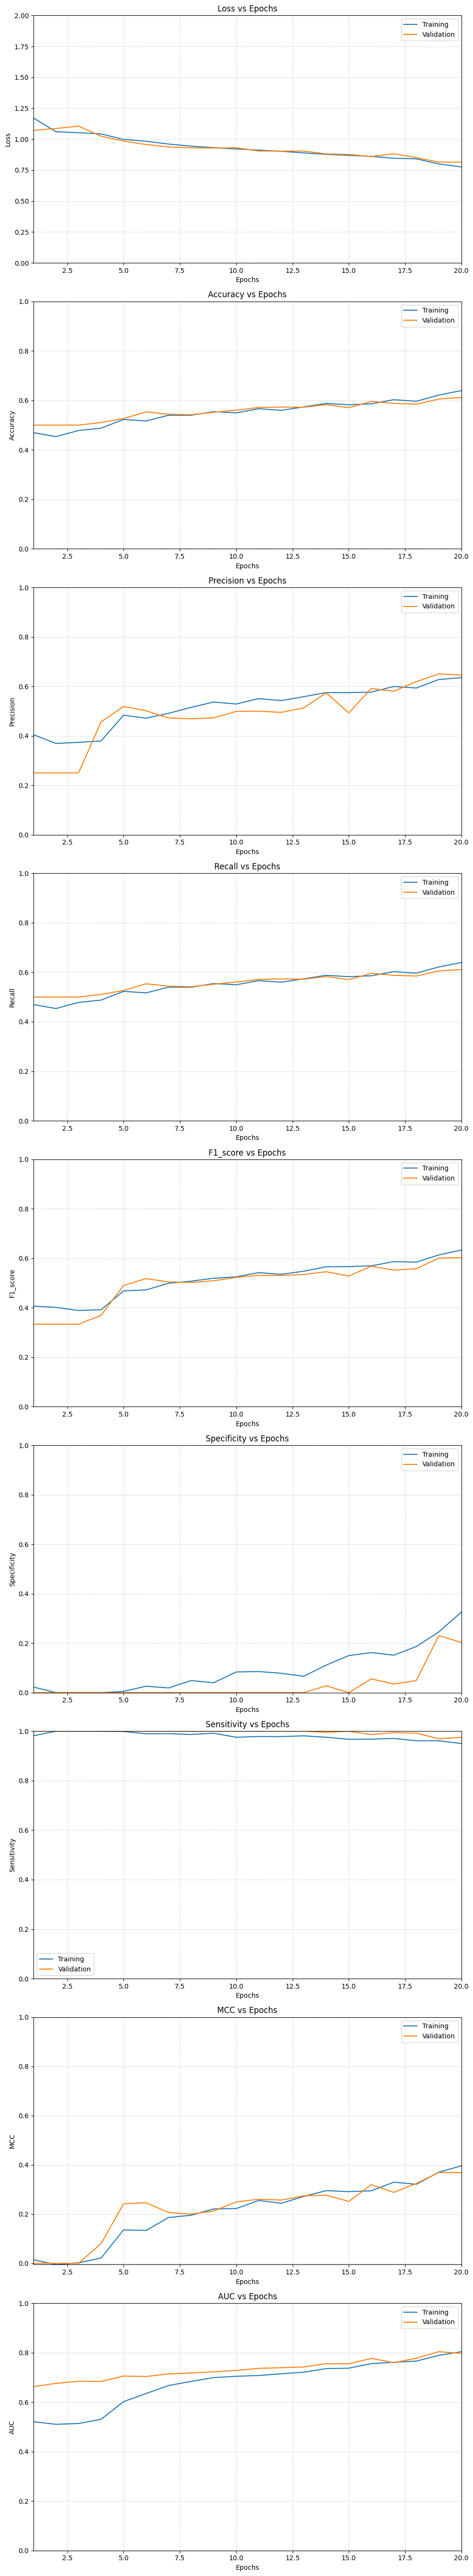

In [25]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [ ]:
# Confusion Matrix
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

# Plot Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

KeyboardInterrupt: 